In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
import datetime

In [22]:
%load_ext tensorboard
tensorboard = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False)

## Data Preprocessing

In [3]:
df = pd.read_csv("af2_dataset_training_labeled.csv.gz", index_col=0)
df.head()

,annotation_sequence,feat_A,feat_C,feat_D,feat_E,feat_F,feat_G,feat_H,feat_I,feat_K,...,feat_DSSP_10,feat_DSSP_11,feat_DSSP_12,feat_DSSP_13,coord_X,coord_Y,coord_Z,entry,entry_index,y_Ligand
0,M,False,False,False,False,False,False,False,False,False,...,0,0.0,47,-0.0,-26.499001,-4.742,-35.189999,GEMI5_HUMAN,0,False
1,G,False,False,False,False,False,True,False,False,False,...,0,0.0,0,0.0,-25.158001,-1.342,-34.104000,GEMI5_HUMAN,1,False
2,Q,False,False,False,False,False,False,False,False,False,...,1,-0.0,-1,-0.0,-21.926001,-1.641,-32.175999,GEMI5_HUMAN,2,False
3,E,False,False,False,True,False,False,False,False,False,...,706,-0.1,705,-0.0,-22.073999,0.654,-29.171000,GEMI5_HUMAN,3,False
4,P,False,False,False,False,False,False,False,False,False,...,0,0.0,705,-0.2,-19.783001,2.670,-26.858999,GEMI5_HUMAN,4,False


In [4]:
# find any missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 497166 entries, 0 to 759
Data columns (total 50 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   annotation_sequence  497166 non-null  object 
 1   feat_A               497166 non-null  bool   
 2   feat_C               497166 non-null  bool   
 3   feat_D               497166 non-null  bool   
 4   feat_E               497166 non-null  bool   
 5   feat_F               497166 non-null  bool   
 6   feat_G               497166 non-null  bool   
 7   feat_H               497166 non-null  bool   
 8   feat_I               497166 non-null  bool   
 9   feat_K               497166 non-null  bool   
 10  feat_L               497166 non-null  bool   
 11  feat_M               497166 non-null  bool   
 12  feat_N               497166 non-null  bool   
 13  feat_P               497166 non-null  bool   
 14  feat_Q               497166 non-null  bool   
 15  feat_R              

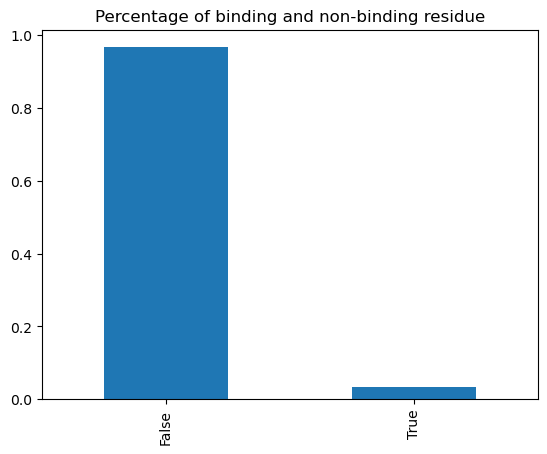

In [5]:
counts = df['y_Ligand'].value_counts() / len(df)
counts.plot.bar()
plt.title('Percentage of binding and non-binding residue')
plt.show()

In [6]:
y = df["y_Ligand"].astype(int)
y = np.array(y)

In [7]:
# dropping columns
# - annotation_sequence: covered by feat_[letter]
# - annotation_atomrec: don't know what exactly it is (almost same as annotation_sequence)
# - entry: object type causes input type problem for the model (bring it back in by one-hot encoding or label encoding if necessary)
# - y_ligand: y value, not necessary for input
df_x = df.drop(['annotation_sequence', 'annotation_atomrec', 'entry', 'y_Ligand'], axis=1)

# convert boolean columns into integer
df_x[df_x.select_dtypes(include='bool').columns] = df_x.select_dtypes(include='bool').astype(int)

# scale data

df_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 497166 entries, 0 to 759
Data columns (total 46 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   feat_A        497166 non-null  int32  
 1   feat_C        497166 non-null  int32  
 2   feat_D        497166 non-null  int32  
 3   feat_E        497166 non-null  int32  
 4   feat_F        497166 non-null  int32  
 5   feat_G        497166 non-null  int32  
 6   feat_H        497166 non-null  int32  
 7   feat_I        497166 non-null  int32  
 8   feat_K        497166 non-null  int32  
 9   feat_L        497166 non-null  int32  
 10  feat_M        497166 non-null  int32  
 11  feat_N        497166 non-null  int32  
 12  feat_P        497166 non-null  int32  
 13  feat_Q        497166 non-null  int32  
 14  feat_R        497166 non-null  int32  
 15  feat_S        497166 non-null  int32  
 16  feat_T        497166 non-null  int32  
 17  feat_V        497166 non-null  int32  
 18  feat_W 

In [8]:
x_train, x_val, y_train, y_val = train_test_split(df_x, y)

In [9]:
# scaling
numeric_cols = x_train.select_dtypes(include=[float, int]).columns
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train[numeric_cols])
x_val_scaled = scaler.fit_transform(x_val[numeric_cols])
x_train_scaled

array([[-0.27070507, -0.14566151, -0.23303469, ..., -0.8361749 ,
        -0.22705362, -0.73775641],
       [-0.27070507, -0.14566151, -0.23303469, ...,  0.88727423,
        -0.61391211, -0.760345  ],
       [-0.27070507, -0.14566151,  4.29120657, ...,  0.66333826,
         0.34683465, -0.5058469 ],
       ...,
       [-0.27070507, -0.14566151, -0.23303469, ...,  1.66070372,
         2.04297665,  0.28174189],
       [-0.27070507, -0.14566151,  4.29120657, ..., -0.53290914,
         0.00479124, -0.52391777],
       [ 3.69405717, -0.14566151, -0.23303469, ..., -1.37631564,
         0.25506508, -0.31158504]])

## For model training & hyperparameter tuning:

In [20]:
# function to train model (create, compile, and fit with validation dataset)
def train(model, x, y, x_val, y_val, lr, epochs, batchsz):
    log_dir = "logs/" + model.name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    print ("MODEL NAME:", model.name)
    optimizer = tf.optimizers.Adam(learning_rate=lr)
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=["accuracy"],
    )
    return model.fit(
        x, 
        y,
        epochs=epochs,
        batch_size=batchsz,
        validation_data=(x_val, y_val),
        callbacks=[tensorboard_callback],
        verbose=1,
    )

In [23]:
%tensorboard --logdir=./logs

Reusing TensorBoard on port 6006 (pid 66476), started 2 days, 3:32:17 ago. (Use '!kill 66476' to kill it.)

## Model 1: simple NN with 3 layers 
Accuracy: 96.62%

In [11]:
# define keras model
model1 = Sequential([
    Dense(12, input_dim=x_train.shape[1], activation='relu'),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [12]:
train(model1, x_train_scaled, y_train, x_val_scaled, y_val, lr=0.001, epochs=50, batchsz=50)

MODEL NAME: sequential
Epoch 1/50
7458/7458 [==============================] - 15s 1ms/step - loss: 0.1402 - accuracy: 0.9643 - val_loss: 0.1322 - val_accuracy: 0.9650
Epoch 2/50
7458/7458 [==============================] - 10s 1ms/step - loss: 0.1293 - accuracy: 0.9654 - val_loss: 0.1294 - val_accuracy: 0.9651
Epoch 3/50
7458/7458 [==============================] - 10s 1ms/step - loss: 0.1270 - accuracy: 0.9655 - val_loss: 0.1275 - val_accuracy: 0.9651
Epoch 4/50
7458/7458 [==============================] - 10s 1ms/step - loss: 0.1252 - accuracy: 0.9658 - val_loss: 0.1255 - val_accuracy: 0.9656
Epoch 5/50
7458/7458 [==============================] - 10s 1ms/step - loss: 0.1240 - accuracy: 0.9659 - val_loss: 0.1255 - val_accuracy: 0.9657
Epoch 6/50
7458/7458 [==============================] - 11s 1ms/step - loss: 0.1233 - accuracy: 0.9660 - val_loss: 0.1244 - val_accuracy: 0.9659
Epoch 7/50
7458/7458 [==============================] - 10s 1ms/step - loss: 0.1226 - accuracy: 0.9661 - va

In [13]:
# evaluate
_, accuracy = model1.evaluate(x_val_scaled, y_val)
print('Accuracy: %.2f' % (accuracy * 100))

3885/3885 [==============================] - 4s 982us/step - loss: 0.1196 - accuracy: 0.9663
Accuracy: 96.63


### Experimenting with learning rate

In [35]:
def tune_lr(model, step_size, num_steps, annealing_ratio, lr): 
    log_dir = "logs/" + model.name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    print ("MODEL NAME:", model.name)
    optimizer = tf.optimizers.Adam(learning_rate=lr)
    model.compile(
          optimizer=optimizer,
          loss=tf.keras.losses.BinaryCrossentropy(),
          metrics=["accuracy"],
    )
    for step in range(num_steps): 
        print('step:', step)
        if step > 0:
          lr = lr * annealing_ratio
        model.fit(
            x_train, 
            y_train,
            epochs=step_size,
            validation_data=(x_val, y_val),
            callbacks=[tensorboard_callback],
        verbose=1,
        )

In [37]:
model1_lrtuned = model1
tune_lr(model1_lrtuned, 5, 8, 0.5, 0.1)

MODEL NAME: sequential_1
Epoch 1/5
11653/11653 [==============================] - 17s 1ms/step - loss: 0.1515 - accuracy: 0.9653 - val_loss: 0.1531 - val_accuracy: 0.9652
Epoch 2/5
11653/11653 [==============================] - 16s 1ms/step - loss: 0.1514 - accuracy: 0.9653 - val_loss: 0.1513 - val_accuracy: 0.9652
Epoch 3/5
11653/11653 [==============================] - 16s 1ms/step - loss: 0.1514 - accuracy: 0.9653 - val_loss: 0.1510 - val_accuracy: 0.9652
Epoch 4/5
11653/11653 [==============================] - 16s 1ms/step - loss: 0.1514 - accuracy: 0.9653 - val_loss: 0.1531 - val_accuracy: 0.9652
Epoch 5/5
11653/11653 [==============================] - 16s 1ms/step - loss: 0.1514 - accuracy: 0.9653 - val_loss: 0.1515 - val_accuracy: 0.9652
Epoch 1/5
11653/11653 [==============================] - 17s 1ms/step - loss: 0.1514 - accuracy: 0.9653 - val_loss: 0.1512 - val_accuracy: 0.9652
Epoch 2/5
11653/11653 [==============================] - 16s 1ms/step - loss: 0.1514 - accuracy: 0.

## Grid search -- need to customize for this dataset
Using hparams dashboard (preview)

Source: https://www.tensorflow.org/tensorboard/hyperparameter_tuning_with_hparams

In [45]:
from tensorboard.plugins.hparams import api as hp

# define the hyperparameters to tune
LEARNING_RATE = hp.HParam('learning_rate', hp.RealInterval(0.001, 0.01))
# HP_BATCH_SIZE = hp.HParam('batch_size', hp.Discrete([16, 32, 64]))
NUM_LAYERS = hp.HParam('num_layers', hp.IntInterval(1, 3))
NUM_UNITS = hp.HParam('num_units', hp.Discrete([8, 12, 16]))
NUM_EPOCHS = hp.HParam('num_epochs', hp.Discrete([10, 20, 30]))

# configuration on TensorBoard
with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(
        hparams=[LEARNING_RATE, NUM_LAYERS, NUM_UNITS, NUM_EPOCHS],
        metrics=[hp.Metric('accuracy', display_name='Accuracy')]
    )

In [52]:
# log hyperparameters and metrics while training
def train_test_model(x, y, x_val, y_val, hparams):
    # create model
    model = Sequential([
        Dense(hparams['NUM_UNITS'], input_dim=x_train.shape[1], activation='relu'),
        Dense(8, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    # Set up logging:
    print ('MODEL NAME:', model.name)
    log_dir = "hparam_logs/" + model.name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    callbacks = [
        tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1),
        hp.KerasCallback(log_dir, hparams),
    ]
    
    #Prepare our model:
    optimizer = tf.optimizers.Adam(learning_rate=hparams['LEARNING_RATE'])
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=['accuracy'],
    )

    #Train:
    return model.fit(
        x, 
        y, 
        epochs=hparams['NUM_EPOCHS'],
        callbacks=callbacks,
        verbose=1
    )

    _, accuracy = model.evaluate(x_val, y_val)
    return accuracy

In [53]:
session_num = 0

for num_layers in (HP_NUM_LAYERS.domain.min_value, HP_NUM_LAYERS.domain.max_value):
    for num_units in HP_NUM_UNITS.domain.values:
        for num_epochs in HP_NUM_EPOCHS.domain.values:
            for learning_rate in (HP_LEARNING_RATE.domain.min_value, HP_LEARNING_RATE.domain.max_value):
                hparams = {
                    'NUM_LAYERS': num_layers,
                    'NUM_UNITS': num_units,
                    'NUM_EPOCHS': num_epochs,
                    'LEARNING_RATE': learning_rate
                }
                run_name = "run-%d" % session_num
                print('--- Starting trial: %s' % run_name)
                print('Current parameters:', hparams)
                train_test_model(x_train, y_train, x_val, y_val, hparams)

--- Starting trial: run-0
Current parameters: {'NUM_LAYERS': 1, 'NUM_UNITS': 8, 'NUM_EPOCHS': 10, 'LEARNING_RATE': 0.001}
MODEL NAME: sequential_3
Epoch 1/10
11653/11653 [==============================] - 13s 1ms/step - loss: 0.1932 - accuracy: 0.9616
Epoch 2/10
11653/11653 [==============================] - 13s 1ms/step - loss: 0.1350 - accuracy: 0.9653
Epoch 3/10
11653/11653 [==============================] - 13s 1ms/step - loss: 0.1298 - accuracy: 0.9654
Epoch 4/10
11653/11653 [==============================] - 13s 1ms/step - loss: 0.1285 - accuracy: 0.9654
Epoch 5/10
11653/11653 [==============================] - 13s 1ms/step - loss: 0.1269 - accuracy: 0.9654
Epoch 6/10
11653/11653 [==============================] - 13s 1ms/step - loss: 0.1259 - accuracy: 0.9654
Epoch 7/10
11653/11653 [==============================] - 14s 1ms/step - loss: 0.1253 - accuracy: 0.9654
Epoch 8/10
11653/11653 [==============================] - 14s 1ms/step - loss: 0.1248 - accuracy: 0.9654
Epoch 9/10
11

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



11653/11653 [==============================] - 14s 1ms/step - loss: 0.1990 - accuracy: 0.9646
Epoch 2/20
11653/11653 [==============================] - 13s 1ms/step - loss: 0.1375 - accuracy: 0.9654
Epoch 3/20
11653/11653 [==============================] - 13s 1ms/step - loss: 0.1361 - accuracy: 0.9654
Epoch 4/20
11653/11653 [==============================] - 14s 1ms/step - loss: 0.1366 - accuracy: 0.9654
Epoch 5/20
11653/11653 [==============================] - 15s 1ms/step - loss: 0.1357 - accuracy: 0.9654
Epoch 6/20
11653/11653 [==============================] - 14s 1ms/step - loss: 0.1351 - accuracy: 0.9654
Epoch 7/20
11653/11653 [==============================] - 14s 1ms/step - loss: 0.1345 - accuracy: 0.9654
Epoch 8/20
11653/11653 [==============================] - 15s 1ms/step - loss: 0.1345 - accuracy: 0.9654
Epoch 9/20
11653/11653 [==============================] - 14s 1ms/step - loss: 0.1343 - accuracy: 0.9654
Epoch 10/20
11653/11653 [==============================] - 16s 1ms

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



11653/11653 [==============================] - 14s 1ms/step - loss: 0.2252 - accuracy: 0.9606
Epoch 2/30
11653/11653 [==============================] - 13s 1ms/step - loss: 0.1444 - accuracy: 0.9650
Epoch 3/30
11653/11653 [==============================] - 14s 1ms/step - loss: 0.1207 - accuracy: 0.9657
Epoch 26/30
11653/11653 [==============================] - 13s 1ms/step - loss: 0.1207 - accuracy: 0.9656
Epoch 27/30
11653/11653 [==============================] - 13s 1ms/step - loss: 0.1205 - accuracy: 0.9657
Epoch 28/30
11653/11653 [==============================] - 13s 1ms/step - loss: 0.1205 - accuracy: 0.9656
Epoch 29/30
11653/11653 [==============================] - 13s 1ms/step - loss: 0.1205 - accuracy: 0.9656
Epoch 30/30
11653/11653 [==============================] - 13s 1ms/step - loss: 0.1203 - accuracy: 0.9657
--- Starting trial: run-0
Current parameters: {'NUM_LAYERS': 1, 'NUM_UNITS': 16, 'NUM_EPOCHS': 30, 'LEARNING_RATE': 0.01}
MODEL NAME: sequential_20
Epoch 1/30
 8675/1

KeyboardInterrupt: 

## Random search
https://stackoverflow.com/questions/40467296/tensorflow-how-to-implement-hyper-parameters-random-search

In [ ]:
def generate_random_hyperparams(lr_min, lr_max, kp_min, kp_max):
    '''generate random learning rate and keep probability'''
    # random search through log space for learning rate
    random_learng_rate = 10**np.random.uniform(lr_min, lr_max)
    random_keep_prob = np.random.uniform(kp_min, kp_max)
    return random_learning_rate, random_keep_prob

## Pretraining